In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.3342993700945819
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.2658301106205693
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.21662350054140445
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.165717707739936
Checkpoint 500, Accuracy: 0.9753086419753086, Loss: 0.14249658584594727


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9307615  0.00149276 0.06774572]
[0. 0. 1.] <-> [0.46260166 0.00059069 0.5368077 ]
[1. 0. 0.] <-> [0.9593055  0.00253727 0.03815721]
[1. 0. 0.] <-> [0.86406416 0.13051485 0.005421  ]
[1. 0. 0.] <-> [0.94261247 0.00220226 0.05518524]
[0. 0. 1.] <-> [1.0782249e-01 1.6788700e-04 8.9200956e-01]
[1. 0. 0.] <-> [0.9807653  0.00552604 0.0137087 ]
[1. 0. 0.] <-> [0.97780436 0.00450429 0.01769144]
[1. 0. 0.] <-> [0.7929121  0.0013546  0.20573327]
[1. 0. 0.] <-> [0.9789473  0.00954559 0.01150719]
[1. 0. 0.] <-> [0.94039536 0.05320087 0.00640376]
[0. 1. 0.] <-> [3.7059817e-02 9.6272874e-01 2.1144662e-04]
[0. 1. 0.] <-> [3.2074358e-02 9.6774399e-01 1.8172871e-04]
[1. 0. 0.] <-> [0.9731449  0.02105005 0.00580501]
[1. 0. 0.] <-> [0.9782708  0.00393639 0.0177928 ]
[0. 1. 0.] <-> [0.24878861 0.7493148  0.00189662]
[1. 0. 0.] <-> [0.9774336  0.00330863 0.01925774]
[1. 0. 0.] <-> [0.80354315 0.00134931 0.1951075 ]
[1. 0. 0.] <-> [0.88637054 0.10957873 0.00405073]
[1. 0. 0.] <-> [0.93252

In [12]:
# Testing Performance

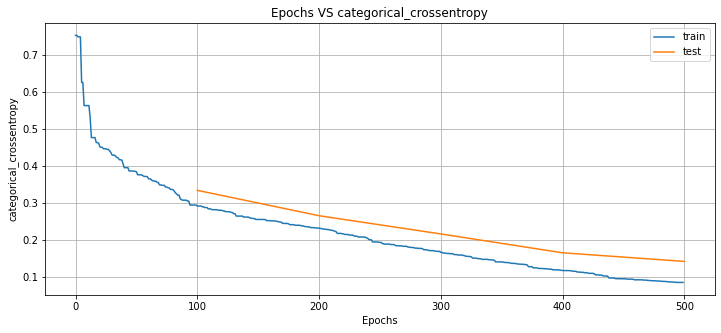

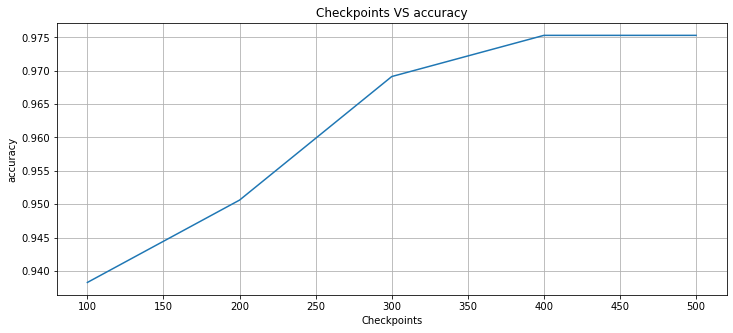

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9382716049382716, 'mean_square_error': 0.17625830727649117, 'categorical_crossentropy': 0.3342993700945819, 'precision': 0.9074074074074074, 'recall': 0.9074074074074074, 'f1': 0.9074074074074074, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 6, 'tn_hit': 22, 'fn_hit': 4}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 2}, 2: {'tp_hit': 9, 'fp_hit': 3, 'tn_hit': 92, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.13233059670869649, 'categorical_crossentropy': 0.2658301106205693, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 6, 'tn_hit': 22, 'fn_hit': 2}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 2}, 2: {'tp_hit': 9, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 4}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.10034482967064016, 'categorical_crossentropy': 0.21662350054140445, 'precision

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-1.228736    2.7225711  -0.29985148 -0.595819   -2.0124247 ]
 bias: -0.8337177038192749

Neuron 1: weights:
[ 0.5122051 -2.1221764 -1.0781925  0.4670113  3.       ]
 bias: -2.4733879566192627

Neuron 2: weights:
[ 2.042715  -2.7620664 -2.297197   1.3233259  2.4647312]
 bias: 2.948272705078125

Neuron 3: weights:
[ 1.3216201 -3.        -0.9349781  1.7048086 -1.4630429]
 bias: 2.152631998062134

$
Layer 2
Neuron 0: weights:
[-0.86539537 -3.          1.4336919   0.4270096 ]
 bias: 0.8533416986465454

Neuron 1: weights:
[ 2.2746542 -2.897196  -3.        -2.1590846]
 bias: 1.123420238494873

Neuron 2: weights:
[-2.9712005   2.980241    1.5537014  -0.35751212]
 bias: -2.2159218788146973

$

